In [26]:
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import gymnasium as gym
import matplotlib.pyplot as plt
import cv2

## Creacion del modelo


In [27]:
# Crear la red neuronal para aproximar Q(s, a)
def build_model(state_dim, action_dim, initial_layer=128, medium_layer=128):
    # with tf.device('/GPU:0'):
    print("initial layer: ", initial_layer)
    print("medium layer: ", medium_layer)
    model = Sequential()
    # recomendacion capa inicla
    model.add(Input(shape=(state_dim,)))
    # agregar activacion capa inicial
    model.add(Dense(initial_layer, activation="relu"))
    model.add(Dense(medium_layer, activation="relu"))
    model.add(Dense(action_dim, activation="linear"))

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
    return model

## Clase DQNAgent con historial de pérdidas


In [28]:
class DQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        replay_size=10000,
        batch_size=64,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        discretization_bins=10,  # Nuevas variables para la discretización
        initial_layer=128,
        medium_layer=128,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = deque(maxlen=replay_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.loss_history = []  # Para almacenar la pérdida promedio por episodio
        self.mae_history = []  # Para almacenar el MAE promedio por episodio
        self.discretization_bins = (
            discretization_bins  # Número de intervalos para discretizar cada dimensión
        )
        self.initial_layer = initial_layer
        self.medium_layer = medium_layer

        # Redes Q y Target
        self.q_network = build_model(state_dim, action_dim, initial_layer, medium_layer)
        self.target_network = build_model(
            state_dim, action_dim, initial_layer, medium_layer
        )
        self.update_target_network()

    def update_target_network(self):
        """Copiar los pesos de la red principal a la red target."""
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state):
        """Selecciona una acción siguiendo la política \(\epsilon\)-greedy."""
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.action_dim - 1)  # Acción aleatoria
        state = np.expand_dims(state, axis=0)
        q_values = self.q_network.predict(state, verbose=0)
        return np.argmax(q_values[0])  # Acción con el mayor valor Q

    def store_experience(self, state, action, reward, next_state, terminated):
        """Almacena la experiencia en el buffer de repetición."""
        self.replay_buffer.append((state, action, reward, next_state, terminated))

    def train(self):
        """Entrena la red Q utilizando un batch de experiencias."""
        if len(self.replay_buffer) < self.batch_size:
            return

        # Muestra un batch aleatorio de experiencias
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, terminateds = zip(*batch)

        states = np.array(states)
        next_states = np.array(next_states)

        # Calcular las predicciones de Q de la red y la red target
        q_values = self.q_network.predict(states, verbose=0)
        q_values_next = self.target_network.predict(next_states, verbose=0)

        # Actualizar Q(s, a) utilizando el valor máximo de la siguiente acción
        for i in range(self.batch_size):
            if terminateds[i]:
                q_values[i, actions[i]] = rewards[i]
            else:
                q_values[i, actions[i]] = rewards[i] + self.gamma * np.max(
                    q_values_next[i]
                )

        # Entrenamiento de la red
        history = self.q_network.fit(states, q_values, epochs=1, verbose=0)

        # Almacenar las métricas de pérdida y MAE
        self.loss_history.append(history.history["loss"][0])
        self.mae_history.append(history.history["mae"][0])

    def discretize_state(self, state):
        """Convierte el estado continuo en un estado discreto"""
        discretized_state = np.zeros(self.state_dim)
        for i in range(self.state_dim):
            discretized_state[i] = np.digitize(
                state[i], np.linspace(-1, 1, self.discretization_bins)
            )
        return tuple(discretized_state)

In [29]:
def plot_scores(scores):
    plt.figure(figsize=(10, 6))
    plt.plot(scores, label="Puntaje por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Puntaje")
    plt.title("Evolución del Puntaje")
    plt.legend()
    plt.grid()
    plt.show()


def plot_loss(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label="Pérdida por batch")
    plt.xlabel("Batch")
    plt.ylabel("Pérdida (Loss)")
    plt.title("Evolución de la Pérdida")
    plt.legend()
    plt.grid()
    plt.show()


def plot_mae(mae_history):
    plt.figure(figsize=(10, 6))
    plt.plot(mae_history, label="MAE por batch")
    plt.xlabel("Batch")
    plt.ylabel("Error Absoluto Medio (MAE)")
    plt.title("Evolución del MAE")
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
from tqdm import tqdm

## Entrenamiento del DQN con métricas y video


In [33]:
def train_dqn(
    env_name="MountainCar-v0",
    episodes=10,
    target_update=10,
    video_filename="dqn_training_video.mp4",
    initial_layer=128,
    medium_layer=128,
    batch_size=64
):
    env = gym.make(env_name, render_mode="rgb_array")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(state_dim, action_dim, initial_layer=initial_layer,medium_layer=medium_layer, batch_size=batch_size)
    scores = []

    env.reset()
    # sample_frame = env.render()[0]
    # height, width, channels = (
    #     sample_frame.shape
    #     if len(sample_frame.shape) == 3
    #     else (sample_frame.shape[0], sample_frame.shape[1], 1)
    # )

    # obj_video = cv2.VideoWriter_fourcc(*"mp4v")
    # out = cv2.VideoWriter(
    #     video_filename, obj_video, 30, (width, height), isColor=(channels == 3)
    # )

    for episode in  tqdm( range(episodes)):
        state = env.reset()[0]
        state = np.array(state, dtype=np.float32)
        episode_score = 0

        while True:
            action = agent.select_action(state)
            next_state, reward, terminated, _, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            episode_score += reward

            if terminated:
                if episode_score >= 200:
                    reward = 100  # Recompensa por alcanzar la meta
                else:
                    reward = -10  # Penalización si no alcanza la meta

            agent.store_experience(state, action, reward, next_state, terminated)
            agent.train()

            state = next_state

            # frame = env.render()[0]
            # frame_bgr = (
            #     cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            #     if len(frame.shape) == 3
            #     else cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            # )
            # out.write(frame_bgr)

            if terminated:
                break

        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        scores.append(episode_score)

        if episode % target_update == 0:
            agent.update_target_network()

        print(
            f"Episode {episode}, Score: {episode_score}, Epsilon: {agent.epsilon:.2f}"
        )

    # out.release()
    env.close()

    plot_scores(scores)
    plot_loss(agent.loss_history)
    plot_mae(agent.mae_history)

    return scores, agent.loss_history, agent.mae_history


### Ambientes

In [15]:
ambientes=['Acrobot-v1','MountainCar-v0','LunarLander-v3']

## Entrenar y graficar resultados


## Mejores resultados

capa inicial 128

capa intermedia 128

batch size 64

In [ ]:
scores, loss_history, mae_history = train_dqn(episodes=10)


## Otras pruebas

capa inicial 64

capa intermedia 128

batch size 64

In [19]:
scores, loss_history, mae_history = train_dqn(
    episodes=10, initial_layer=64, medium_layer=128
)

initial layer:  64
medium layer:  128
initial layer:  64
medium layer:  128


  0%|          | 0/10 [03:36<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
scores, loss_history, mae_history = train_dqn(episodes=10)

# pytorch

In [9]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import cv2

In [10]:
# Modelo de red neuronal
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, initial_layer=128, medium_layer=128):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, initial_layer)
        self.fc2 = nn.Linear(medium_layer, medium_layer)
        self.fc3 = nn.Linear(medium_layer, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [11]:
class DQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        replay_size=10000,
        batch_size=64,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.999,
        epsilon_min=0.01,
        discretization_bins=10,
        lr=1e-4,
        initial_layer=128,
        medium_layer=128,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = deque(maxlen=replay_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.loss_history = []
        self.mae_history = []
        self.discretization_bins = discretization_bins
        self.initial_layer = initial_layer
        self.medium_layer = medium_layer

        # Redes Q y Target
        self.q_network = DQN(
            state_dim, action_dim, self.initial_layer, self.medium_layer
        ).float()
        self.target_network = DQN(
            state_dim, action_dim, self.initial_layer, self.medium_layer
        ).float()
        self.update_target_network()

        self.optimizer = optim.Adam(
            self.q_network.parameters(), lr=lr, weight_decay=1e-5
        )
        self.criterion = nn.SmoothL1Loss()

    def update_target_network(self):
        """Copiar los pesos de la red principal a la red target."""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def select_action(self, state):
        """Selecciona una acción siguiendo la política \(\epsilon\)-greedy."""
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.action_dim - 1)  # Acción aleatoria
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state)
        return torch.argmax(q_values).item()  # Acción con el mayor valor Q

    def store_experience(self, state, action, reward, next_state, terminated):
        """Almacena la experiencia en el buffer de repetición."""
        self.replay_buffer.append((state, action, reward, next_state, terminated))

    def train(self):
        """Entrena la red Q utilizando un batch de experiencias."""
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, terminateds = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        terminateds = torch.tensor(terminateds, dtype=torch.float32)

        # Q valores actuales y valores objetivos
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            q_values_next = self.target_network(next_states).max(1)[0]
            targets = rewards + self.gamma * q_values_next * (1 - terminateds)

        loss = self.criterion(q_values, targets)

        # Optimización de la red
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.loss_history.append(loss.item())
        self.mae_history.append(torch.abs(q_values - targets).mean().item())

    


In [17]:
def discretize_state(state, pos_space, vel_space):
    """Discretiza el estado continuo en segmentos discretos."""
    position, velocity = state
    pos_idx = np.digitize(position, pos_space) - 1
    vel_idx = np.digitize(velocity, vel_space) - 1
    return (pos_idx, vel_idx)

In [12]:
def plot_scores(scores):
    plt.plot(scores)
    plt.title("Episodic Scores")
    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.show()

def plot_loss(loss_history):
    plt.plot(loss_history)
    plt.title("Loss History")
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.show()

def plot_mae(mae_history):
    plt.plot(mae_history)
    plt.title("Mean Absolute Error (MAE)")
    plt.xlabel("Episodes")
    plt.ylabel("MAE")
    plt.show()

In [33]:
from tqdm import tqdm 

In [42]:
def train_dqn(
    env_name="MountainCar-v0",
    episodes=10,
    target_update=10,
    # video_filename="dqn_training_video.mp4",
    initial_layer=128,
    medium_layer=128,
):
    env = gym.make(env_name, render_mode="rgb_array")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Divide position and velocity into segments
    pos_space = np.linspace(
        env.observation_space.low[0], env.observation_space.high[0], 20
    )  # Between -1.2 and 0.6
    vel_space = np.linspace(
        env.observation_space.low[1], env.observation_space.high[1], 20
    )  # Between -0.07 and 0.07

    agent = DQNAgent(
        state_dim, action_dim, initial_layer=initial_layer, medium_layer=medium_layer
    )
    scores = []

    env.reset()
    # sample_frame = env.render()[0]
    # height, width, channels = (
    #     sample_frame.shape
    #     if len(sample_frame.shape) == 3
    #     else (sample_frame.shape[0], sample_frame.shape[1], 1)
    # )

    # obj_video = cv2.VideoWriter_fourcc(*"mp4v")
    # out = cv2.VideoWriter(
    #     video_filename, obj_video, 30, (width, height), isColor=(channels == 3)
    # )

    for episode in tqdm(range(episodes)):
        state = env.reset()[0]  # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        episode_score = 0


        while True:
            # discretized_state = agent.discretize_state(state, pos_space, vel_space)
            # state_tensor = np.array(discretized_state, dtype=np.float32)

            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_state_p = np.digitize(next_state[0], pos_space)
            next_state_v = np.digitize(next_state[1], vel_space)

            episode_score += reward

            # # Recompensa informativa
            # goal_position = 0.5
            # reward += (next_state[0] - state[0]) * 10  # Recompensa por acercarse
            # reward += abs(next_state[1])  # Recompensa por velocidad

            # if next_state_p[0] >= goal_position:
            #     reward += 100  # Meta alcanzada
            # elif truncated:
            #     reward -= 10  # Penalización por tiempo agotado

            if terminated:
                if episode_score >= 200:
                    reward = 100  # Recompensa por alcanzar la meta
                else:
                    reward = -10  # Penalización si no alcanza la meta

            agent.store_experience(state, action, reward, next_state, terminated)
            agent.train()

            state = next_state
            state_p = next_state_p
            state_v = next_state_v

            # frame = env.render()[0]
            # frame_bgr = (
            #     cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            #     if len(frame.shape) == 3
            #     else cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            # )
            # out.write(frame_bgr)

            if terminated or truncated:
                break

        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        scores.append(episode_score)

        if episode % target_update == 0:
            agent.update_target_network()

        # print(
        #     f"Episode {episode}, Score: {episode_score}, Epsilon: {agent.epsilon:.2f}"
        # )

    # out.release()
    env.close()

    plot_scores(scores)
    plot_loss(agent.loss_history)
    plot_mae(agent.mae_history)

    return scores, agent.loss_history, agent.mae_history

100%|██████████| 100/100 [01:32<00:00,  1.09it/s]


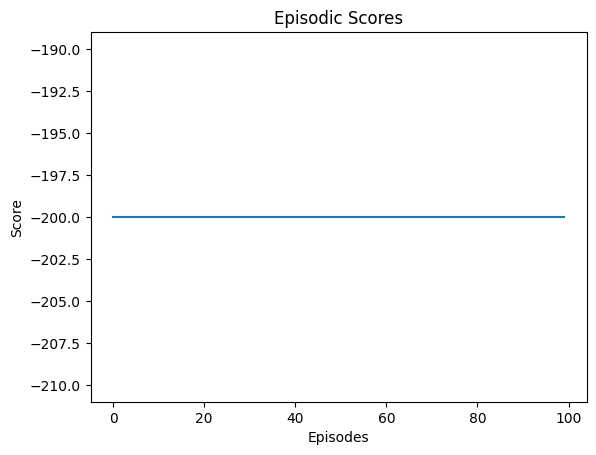

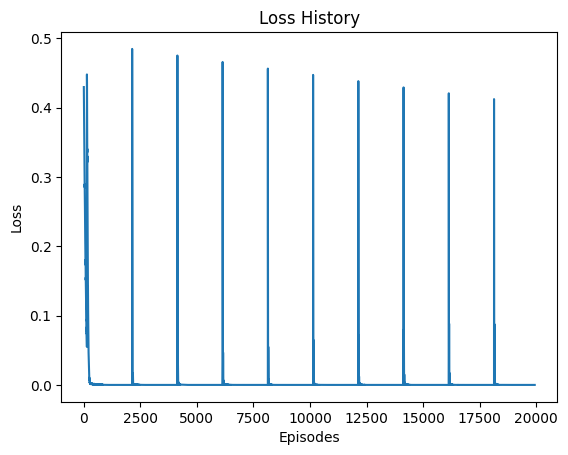

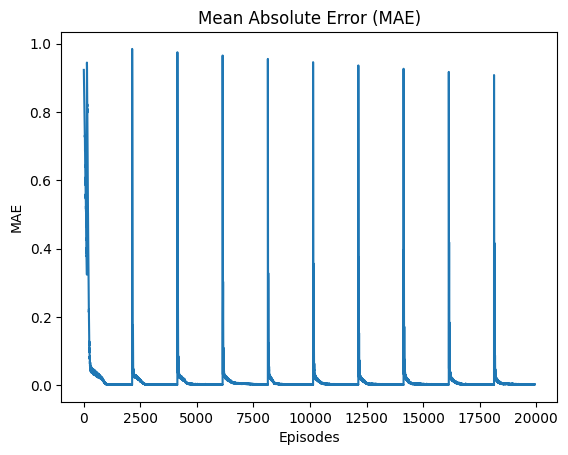

In [43]:
scores = train_dqn(episodes=100)